In [1]:
import pickle
import pandas as pd
import warnings
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
import statsmodels.api as sm
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#file_path = 'monthly_data/regression_data_sensor.pkl'
#with open(file_path, 'rb') as file:
#    flow=pickle.load(file)
#censusdata = pickle.load( open( "diff_in_diff.p", "rb" ) )
#new = censusdata.groupby(['zipcode'])
#results = new.sum()
flow = pd.read_pickle("sensor_traffic_updated.pkl") 
flow

,sensorid,2020_05,2020_06,2022_05,2022_06,zip,total,hispanic,non-hispanic white,non-hispanic black,...,industry_7,industry_8,industry_9,industry_10,industry_11,industry_12,industry_13,num_cars,diverse index,diffindiff
3,10002-W,184.104053,154.057491,250.019090,327.968811,91401,40405.0,16826.0,17465.0,2215.0,...,0.095,0.062,0.132,0.187,0.124,0.080,0.030,29075,0.632073,239.826357
6,10006-N,55.087401,47.334460,74.915365,99.976389,91401,40405.0,16826.0,17465.0,2215.0,...,0.095,0.062,0.132,0.187,0.124,0.080,0.030,29075,0.632073,72.469892
7,10006-S,36.502758,31.810210,50.718381,67.427937,91401,40405.0,16826.0,17465.0,2215.0,...,0.095,0.062,0.132,0.187,0.124,0.080,0.030,29075,0.632073,49.833351
8,10006-W,205.477635,171.600031,275.009698,360.761452,91401,40405.0,16826.0,17465.0,2215.0,...,0.095,0.062,0.132,0.187,0.124,0.080,0.030,29075,0.632073,258.693484
9,10007-N,64.171721,54.205945,86.484721,109.667704,91401,40405.0,16826.0,17465.0,2215.0,...,0.095,0.062,0.132,0.187,0.124,0.080,0.030,29075,0.632073,77.774760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,9313-W,16.765192,14.535697,29.604236,29.197236,91311,41811.0,12054.0,18321.0,2891.0,...,0.034,0.083,0.128,0.263,0.076,0.062,0.024,33117,0.693299,27.500583
9289,9314-E,27.602726,24.799490,49.331998,53.026591,91311,41811.0,12054.0,18321.0,2891.0,...,0.034,0.083,0.128,0.263,0.076,0.062,0.024,33117,0.693299,49.956373
9290,9314-N,153.953032,132.174594,291.371158,314.303588,91311,41811.0,12054.0,18321.0,2891.0,...,0.034,0.083,0.128,0.263,0.076,0.062,0.024,33117,0.693299,319.547120
9291,9314-S,165.185528,154.743735,333.708643,370.404706,91311,41811.0,12054.0,18321.0,2891.0,...,0.034,0.083,0.128,0.263,0.076,0.062,0.024,33117,0.693299,384.184087


In [3]:
percentage_change_05 = [(flow['2022_05'][i]-flow['2020_05'][i])/flow['2020_05'][i] for i in flow.index]
percentage_change_05 = pd.Series(percentage_change_05,index = flow.index)
flow['percentage_change_05']=percentage_change_05
percentage_change_06 = [(flow['2022_06'][i]-flow['2020_06'][i])/flow['2020_06'][i] for i in flow.index]
percentage_change_06 = pd.Series(percentage_change_06,index = flow.index)
flow['percentage_change_06']=percentage_change_06
flow = flow[flow['percentage_change_06']<=3]
flow = flow[flow['percentage_change_05']<=3]
average_percentage_change = [(flow['percentage_change_06'][i]+flow['percentage_change_05'][i])/2 for i in flow.index]
average_percentage_change = pd.Series(average_percentage_change,index = flow.index)
flow['average_percentage_change']=average_percentage_change

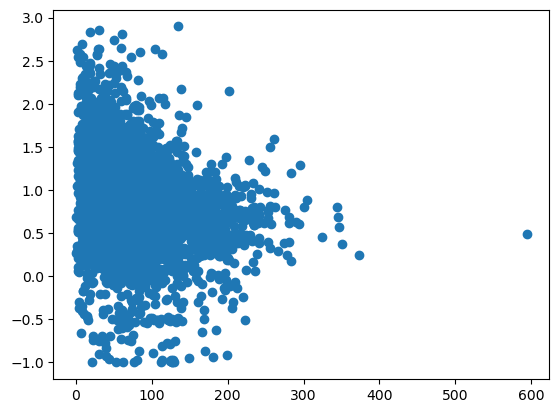

In [4]:
plt.scatter(flow['2020_05'],flow['percentage_change_05'])

In [5]:
flow[flow['2020_05']>500]

,sensorid,2020_05,2020_06,2022_05,2022_06,zip,total,hispanic,non-hispanic white,non-hispanic black,...,industry_10,industry_11,industry_12,industry_13,num_cars,diverse index,diffindiff,percentage_change_05,percentage_change_06,average_percentage_change
3513,15083-W,594.593521,493.819986,884.874206,941.470369,91343,65344.0,39018.0,12854.0,2688.0,...,0.201,0.121,0.071,0.029,44371,0.58315,737.931068,0.4882,0.906505,0.697353


In [6]:
#modified_flow = flow.drop('sensorid', axis=1)

#grouped = modified_flow.groupby(['zip'])
#results = grouped.mean()

In [7]:
#flow = results

In [8]:
data1p = [i for i in flow['total']]
data1e = [i for i in flow['employed_ratio']]
data1i = [i for i in flow['median income (dollars)']]
data1w = [i for i in flow['hispanic_ratio']]
data1b = [i for i in flow['black_ratio']]
data1a = [i for i in flow['asian_ratio']]
data1h = [i for i in flow['other_ratio']]
data1d = [i for i in flow['population density']]
data1di = [i for i in flow['diverse index']]

data1traffic = np.array([i for i in flow['average_percentage_change']])

#train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
#                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
#                  data1cl1,data1cl2,data1cl3,data1car]).T 
train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

#lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','cars'])
lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index'])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     64.31
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          2.83e-110
Time:                        16:58:12   Log-Likelihood:                -2748.8
No. Observations:                3767   AIC:                             5518.
Df Residuals:                    3757   BIC:                             5580.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.5801      0.518      4.981      0.000       1.565       3.596
total population    -1.567e-06   5.58e-07     -2.809      0.005   -2.66e-06   -4.73e-07
employment ratio       -1.3851      0.607     -2.282      0.023      -2.575      -0.195
median income       -2.573e-07   9.85e-07     -0.261      0.794   -2.19e-06    1.67e-06
hispanic proportion    -0.6621      0.111     -5.988      0.000      -0.879      -0.445
black proportion       -0.1022      0.106     -0.965      0.334      -0.310       0.105
asian proportion        0.0489      0.136      0.358      0.720      -0.219       0.316
other proportion        0.9482      0.985      0.963      0.336      -0.983       2.879
population density   8.454e-06   1.52e-06      5.556      0.000    5.47e-06    1.14e-05
diverse index           0.1222      0.103      1.191      0.234      -0.079       0.323
==============================================================================
Omnibus:                      318.118   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.115
Skew:                          -0.492   Prob(JB):                    6.65e-175
Kurtosis:                       5.035   Cond. No.                     9.83e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
data1p = [i for i in flow['total']]
data1e = [i for i in flow['employed_ratio']]
data1i = [i for i in flow['median income (dollars)']]
data1w = [i for i in flow['hispanic_ratio']]
data1b = [i for i in flow['black_ratio']]
data1a = [i for i in flow['asian_ratio']]
data1h = [i for i in flow['other_ratio']]
data1d = [i for i in flow['population density']]
data1di = [i for i in flow['diverse index']]

data1c1 = [i for i in flow['commuting_drove_alone']]
data1c2 = [i for i in flow['commuting_carpool']]
data1c3 = [i for i in flow['commuting_public']]
data1c4 = [i for i in flow['commuting_walked']]
data1c5 = [i for i in flow['commuting_at_home']]
data1c6 = [i for i in flow['commuting_time']]

data1cl1 = [i for i in flow['class_private_wage']]
data1cl2 = [i for i in flow['class_government']]
data1cl3 = [i for i in flow['class_self']]

data1i1 = [i for i in flow['industry_1']]
data1i2 = [i for i in flow['industry_2']]
data1i3 = [i for i in flow['industry_3']]
data1i4 = [i for i in flow['industry_4']]
data1i5 = [i for i in flow['industry_5']]
data1i6 = [i for i in flow['industry_6']]
data1i7 = [i for i in flow['industry_7']]
data1i8 = [i for i in flow['industry_8']]
data1i9 = [i for i in flow['industry_9']]
data1i10 = [i for i in flow['industry_10']]
data1i11 = [i for i in flow['industry_11']]
data1i12 = [i for i in flow['industry_12']]

data1car = [i for i in flow['num_cars']]



data1traffic = np.array([i for i in flow['average_percentage_change']])

train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
                  data1cl1,data1cl2,data1cl3,
                 data1i1,data1i2,data1i3,data1i4,data1i5,data1i6,data1i7,data1i8,data1i9,data1i10,data1i11,data1i12,data1car]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','1','2','3','4','5','6','7','8','9','10','11','12','cars'])

#1:Agriculture, forestry, fishing and hunting, and mining
#2:Construction
#3:Manufacturing
#4:Wholesale trade
#5:Retail trade
#6:Transportation and warehousing, and utilities
#7:Information
#8:Finance and insurance, and real estate and rental and leasing
#9:Professional, scientific, and management, and administrative and waste management services
#10:Educational services, and health care and social assistance
#11:Arts, entertainment, and recreation, and accommodation and food services
#12:Other services, except public administration
#13:Public administration

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     44.07
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          7.00e-226
Time:                        16:58:12   Log-Likelihood:                -2431.6
No. Observations:                3767   AIC:                             4927.
Df Residuals:                    3735   BIC:                             5127.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -35.2484     10.499     -3.357      0.001     -55.833     -14.664
total population    -4.916e-06   9.94e-07     -4.947      0.000   -6.87e-06   -2.97e-06
employment ratio        0.1401      1.017      0.138      0.890      -1.855       2.135
median income        7.235e-06   1.47e-06      4.933      0.000    4.36e-06    1.01e-05
hispanic proportion     1.3362      0.215      6.229      0.000       0.916       1.757
black proportion        1.1691      0.281      4.165      0.000       0.619       1.719
asian proportion        1.3511      0.269      5.019      0.000       0.823       1.879
other proportion        2.1808      1.571      1.389      0.165      -0.898       5.260
population density  -3.455e-06   4.34e-06     -0.795      0.426    -1.2e-05    5.06e-06
diverse index           0.1075      0.205      0.525      0.600      -0.294       0.509
drove alone            -5.5788      1.447     -3.856      0.000      -8.416      -2.742
carpool                -7.0328      1.701     -4.133      0.000     -10.369      -3.697
public                 -6.7734      1.540     -4.399      0.000      -9.792      -3.754
walked                  0.9301      1.800      0.517      0.605      -2.599       4.459
at home               -11.4893      1.673     -6.866      0.000     -14.770      -8.208
time                    0.0154      0.007      2.177      0.030       0.002       0.029
private wage           59.2763      9.380      6.320      0.000      40.887      77.666
government             50.9946      9.550      5.340      0.000      32.270      69.719
self                   63.7191      9.341      6.822      0.000      45.405      82.033
1                      -5.0278      4.733     -1.062      0.288     -14.308       4.252
2                     -24.1928      3.350     -7.221      0.000     -30.762     -17.624
3                     -20.4103      2.824     -7.228      0.000     -25.947     -14.874
4                     -21.6693      3.480     -6.227      0.000     -28.492     -14.847
5                     -16.1931      3.057     -5.296      0.000     -22.187     -10.199
6                     -17.7132      2.783     -6.365      0.000     -23.169     -12.257
7                     -12.4906      3.766     -3.317      0.001     -19.874      -5.107
8                     -11.6775      3.417     -3.418      0.001     -18.376      -4.979
9                     -20.4759      2.695     -7.598      0.000     -25.759     -15.192
10                    -20.7156      2.958     -7.003      0.000     -26.515     -14.916
11                    -20.2533      2.830     -7.156      0.000     -25.802     -14.704
12                    -20.3757      3.219     -6.329      0.000     -26.688     -14.064
cars                 6.164e-06   9.82e-07      6.276      0.000    4.24e-06    8.09e-06
===

In [10]:
data1p = [i for i in flow['total']]
data1e = [i for i in flow['employed_ratio']]
data1i = [i for i in flow['median income (dollars)']]
data1d = [i for i in flow['population density']]
data1di = [i for i in flow['diverse index']]

data1traffic = np.array([i for i in flow['average_percentage_change']])

#train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
#                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
#                  data1cl1,data1cl2,data1cl3,data1car]).T 
train = np.array([data1p,data1e,data1i,data1d,data1di]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

#lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','cars'])
lr1.summary(xname=['const','total population', 'employment ratio','median income','population density','diverse index'])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     103.8
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          7.61e-103
Time:                        16:58:12   Log-Likelihood:                -2775.3
No. Observations:                3767   AIC:                             5563.
Df Residuals:                    3761   BIC:                             5600.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.6888      0.496      7.434      0.000       2.716       4.662
total population   -3.478e-06   4.52e-07     -7.697      0.000   -4.36e-06   -2.59e-06
employment ratio      -3.4331      0.538     -6.387      0.000      -4.487      -2.379
median income       4.773e-06   6.23e-07      7.662      0.000    3.55e-06    5.99e-06
population density  1.035e-05   1.49e-06      6.956      0.000    7.43e-06    1.33e-05
diverse index          0.5819      0.060      9.734      0.000       0.465       0.699
==============================================================================
Omnibus:                      281.850   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.215
Skew:                          -0.437   Prob(JB):                    9.91e-155
Kurtosis:                       4.937   Cond. No.                     7.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
X = flow[['total','employed_ratio','median income (dollars)','population density','diverse index']]
X = sm.add_constant(X)  # Add a constant (intercept)

y = flow['average_percentage_change']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                OLS Regression Results                               
Dep. Variable:     average_percentage_change   R-squared:                       0.121
Model:                                   OLS   Adj. R-squared:                  0.120
Method:                        Least Squares   F-statistic:                     103.8
Date:                       Mon, 04 Dec 2023   Prob (F-statistic):          7.61e-103
Time:                               16:58:12   Log-Likelihood:                -2775.3
No. Observations:                       3767   AIC:                             5563.
Df Residuals:                           3761   BIC:                             5600.
Df Model:                                  5                  

In [12]:
flow.columns

Index(['sensorid', '2020_05', '2020_06', '2022_05', '2022_06', 'zip', 'total',
       'hispanic', 'non-hispanic white', 'non-hispanic black',
       'non-hispanic asian', 'non-hispanic other', 'employed', 'unemployed',
       'median income (dollars)', 'mean income (dollars)', 'other_ratio',
       'black_ratio', 'white_ratio', 'asian_ratio', 'hispanic_ratio',
       'employed_ratio', 'population density', 'commuting_drove_alone',
       'commuting_carpool', 'commuting_public', 'commuting_walked',
       'commuting_other', 'commuting_at_home', 'commuting_time',
       'class_private_wage', 'class_government', 'class_self', 'class_unpaid',
       'industry_1', 'industry_2', 'industry_3', 'industry_4', 'industry_5',
       'industry_6', 'industry_7', 'industry_8', 'industry_9', 'industry_10',
       'industry_11', 'industry_12', 'industry_13', 'num_cars',
       'diverse index', 'diffindiff', 'percentage_change_05',
       'percentage_change_06', 'average_percentage_change'],
      dtype

In [13]:
X = flow[['total','population density','other_ratio', 'black_ratio','asian_ratio', 'hispanic_ratio','diverse index']]
X = sm.add_constant(X)  # Add a constant (intercept)

y = flow['average_percentage_change']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                OLS Regression Results                               
Dep. Variable:     average_percentage_change   R-squared:                       0.131
Model:                                   OLS   Adj. R-squared:                  0.130
Method:                        Least Squares   F-statistic:                     81.17
Date:                       Mon, 04 Dec 2023   Prob (F-statistic):          3.69e-110
Time:                               16:58:12   Log-Likelihood:                -2753.6
No. Observations:                       3767   AIC:                             5523.
Df Residuals:                           3759   BIC:                             5573.
Df Model:                                  7                  

In [14]:
X = flow[['total','population density','median income (dollars)','employed_ratio','class_private_wage', 'class_government',
       'class_self', 'industry_1', 'industry_2', 'industry_3',
       'industry_4', 'industry_5', 'industry_7', 'industry_8',
       'industry_9', 'industry_10', 'industry_11', 'industry_12',
       'industry_13']]
X = sm.add_constant(X)  # Add a constant (intercept)

y = flow['average_percentage_change']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                OLS Regression Results                               
Dep. Variable:     average_percentage_change   R-squared:                       0.206
Model:                                   OLS   Adj. R-squared:                  0.202
Method:                        Least Squares   F-statistic:                     51.21
Date:                       Mon, 04 Dec 2023   Prob (F-statistic):          1.21e-171
Time:                               16:58:12   Log-Likelihood:                -2583.8
No. Observations:                       3767   AIC:                             5208.
Df Residuals:                           3747   BIC:                             5332.
Df Model:                                 19                  

In [15]:
X = flow[['total','population density', 'commuting_carpool', 'commuting_public',
       'commuting_walked', 'commuting_other', 'commuting_at_home',
       'commuting_time','num_cars']]
X = sm.add_constant(X)  # Add a constant (intercept)

y = flow['diffindiff']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:             diffindiff   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     21.62
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           4.28e-36
Time:                        16:58:12   Log-Likelihood:                -23193.
No. Observations:                3767   AIC:                         4.641e+04
Df Residuals:                    3757   BIC:                         4.647e+04
Df Model:                           9                                         
Covariance Type:            nonrobust  

In [16]:
X = flow[['total','median income (dollars)', 'other_ratio', 'black_ratio',
       'asian_ratio', 'hispanic_ratio', 'employed_ratio', 'population density', 'commuting_carpool', 'commuting_public',
       'commuting_walked', 'commuting_other', 'commuting_at_home',
       'commuting_time', 'class_private_wage', 'class_government',
       'class_self', 'industry_1', 'industry_2', 'industry_3',
       'industry_4', 'industry_5', 'industry_7', 'industry_8',
       'industry_9', 'industry_10', 'industry_11', 'industry_12',
       'industry_13', 'num_cars', 'diverse index']]
X = sm.add_constant(X)  # Add a constant (intercept)

y = flow['average_percentage_change']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                OLS Regression Results                               
Dep. Variable:     average_percentage_change   R-squared:                       0.265
Model:                                   OLS   Adj. R-squared:                  0.259
Method:                        Least Squares   F-statistic:                     43.46
Date:                       Mon, 04 Dec 2023   Prob (F-statistic):          5.65e-223
Time:                               16:58:12   Log-Likelihood:                -2438.5
No. Observations:                       3767   AIC:                             4941.
Df Residuals:                           3735   BIC:                             5140.
Df Model:                                 31                  

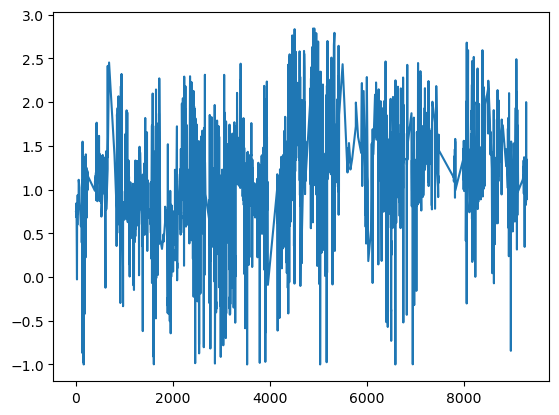

In [17]:
plt.plot(flow['average_percentage_change'])

(array([  28.,   72.,  106.,  252.,  969., 1352.,  619.,  229.,  102.,
          38.]),
 array([-0.9999268 , -0.61571082, -0.23149484,  0.15272114,  0.53693712,
         0.9211531 ,  1.30536908,  1.68958505,  2.07380103,  2.45801701,
         2.84223299]),
 <BarContainer object of 10 artists>)

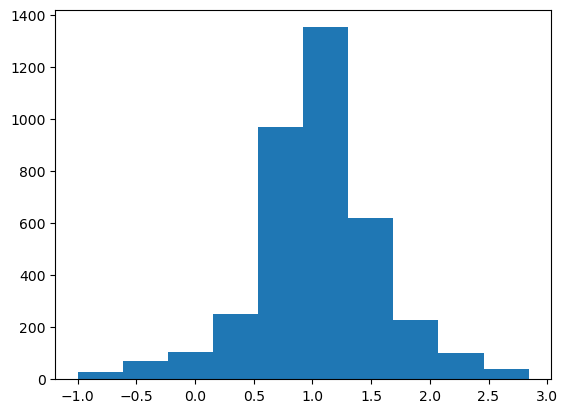

In [18]:
plt.hist(flow['average_percentage_change'])

In [19]:
len(set(flow['zip'].values))

55